# Engineering graduate salary prediction

In [56]:
# Import necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Load the dataset
data_path = os.path.abspath("./data/Engineering_graduate_salary.csv")
data = pd.read_csv(data_path)

# Make a copy of the data
copy_data = data.copy()

# List all columns explicitly with meaningful selection
cols = [
    'ID',  # A unique ID to identify a candidate
    'Salary',  # Annual CTC offered to the candidate (in INR)
    'Gender',  # Candidate's gender
    'DOB',  # Date of birth of the candidate
    '10percentage',  # Overall marks obtained in grade 10 examinations
    '10board',  # The school board followed in grade 10
    '12graduation',  # Year of graduation - senior year high school
    '12percentage',  # Overall marks obtained in grade 12 examinations
    '12board',  # The school board followed in grade 12
    'CollegeID',  # Unique ID for the college
    'CollegeTier',  # College tier based on AMCAT scores
    'Degree',  # Degree pursued by the candidate
    'Specialization',  # Specialization pursued by the candidate
    'collegeGPA',  # Aggregate GPA at graduation
    'CollegeCityID',  # Unique ID for the college's city
    'CollegeCityTier',  # City tier based on population
    'CollegeState',  # State in which the college is located
    'GraduationYear',  # Year of graduation (Bachelor's degree)
    'English',  # Scores in AMCAT English section
    'Logical',  # Scores in AMCAT Logical ability section
    'Quant',  # Scores in AMCAT Quantitative ability section
    'Domain',  # Scores in AMCAT domain module
    'ComputerProgramming',  # Scores in AMCAT Computer programming section
    'ElectronicsAndSemicon',  # Scores in Electronics & Semiconductor section
    'ComputerScience',  # Scores in Computer Science section
    'MechanicalEngg',  # Scores in Mechanical Engineering section
    'ElectricalEngg',  # Scores in Electrical Engineering section
    'TelecomEngg',  # Scores in Telecommunication Engineering section
    'CivilEngg',  # Scores in Civil Engineering section
    'conscientiousness',  # AMCAT personality test score - Conscientiousness
    'agreeableness',  # AMCAT personality test score - Agreeableness
    'extraversion',  # AMCAT personality test score - Extraversion
    'nueroticism',  # AMCAT personality test score - Neuroticism
    'openess_to_experience'  # AMCAT personality test score - Openness to experience
]

# Select and rearrange columns
dtf = data[cols]

# Display the first few rows of the modified DataFrame
dtf.head()


,ID,Salary,Gender,DOB,10percentage,10board,12graduation,12percentage,12board,CollegeID,...,ComputerScience,MechanicalEngg,ElectricalEngg,TelecomEngg,CivilEngg,conscientiousness,agreeableness,extraversion,nueroticism,openess_to_experience
0,604399,445000,f,1990-10-22,87.80,cbse,2009,84.00,cbse,6920,...,-1,-1,-1,-1,-1,-0.1590,0.3789,1.2396,0.14590,0.2889
1,988334,110000,m,1990-05-15,57.00,cbse,2010,64.50,cbse,6624,...,-1,-1,-1,-1,-1,1.1336,0.0459,1.2396,0.52620,-0.2859
2,301647,255000,m,1989-08-21,77.33,"maharashtra state board,pune",2007,85.17,amravati divisional board,9084,...,-1,-1,-1,260,-1,0.5100,-0.1232,1.5428,-0.29020,-0.2875
3,582313,420000,m,1991-05-04,84.30,cbse,2009,86.00,cbse,8195,...,-1,-1,-1,-1,-1,-0.4463,0.2124,0.3174,0.27270,0.4805
4,339001,200000,f,1990-10-30,82.00,cbse,2008,75.00,cbse,4889,...,-1,-1,-1,-1,-1,-1.4992,-0.7473,-1.0697,0.06223,0.1864


# Visualization 1: Distribution of Salaries
### Why is this Feature Significant?
The Salary feature is significant because it is the target variable in the regression problem, and understanding its distribution helps identify outliers, assess skewness, and evaluate the spread, all of which are crucial for proper model preprocessing and improving prediction accuracy.

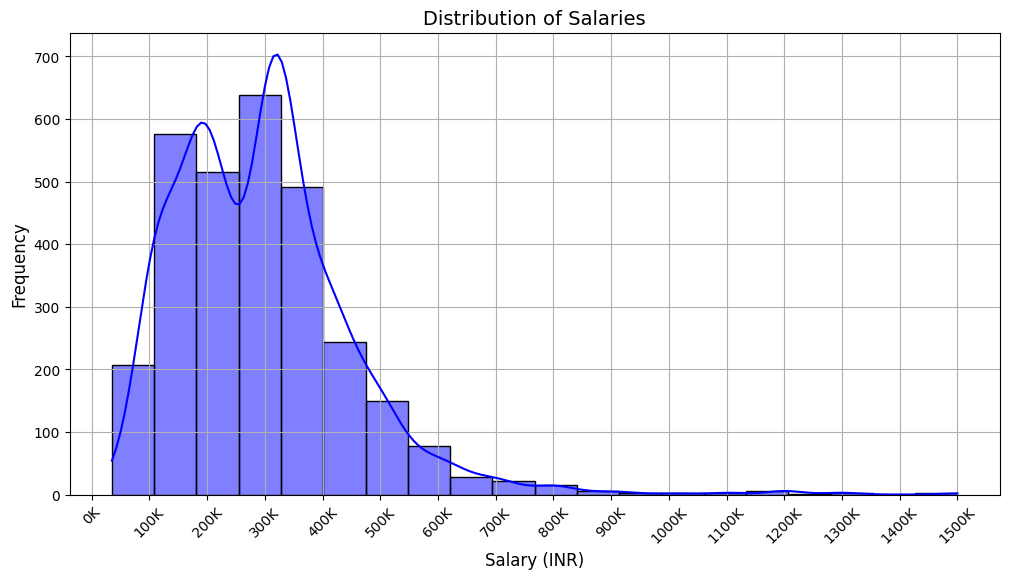

In [57]:
plt.figure(figsize=(12, 6))

# Focus on salaries within a readable range (e.g., < 1,500,000 INR)
filtered_data = copy_data[copy_data['Salary'] <= 1500000]

sns.histplot(filtered_data['Salary'], kde=True, bins=20, color='blue')

# Adding more meaningful X-axis labels
plt.title("Distribution of Salaries", fontsize=14)
plt.xlabel("Salary (INR)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Set X-axis ticks in thousands or lakhs
salary_ticks = range(0, 1600000, 100000)  # Tick every 100,000 INR
salary_labels = [f"{tick//1000}K" for tick in salary_ticks]  # Convert to 'K' notation
plt.xticks(salary_ticks, salary_labels, rotation=45)  # Rotate for clarity

plt.grid(True)
plt.show()


## Why is it Chosen as a Key Visualization?
The Salary Distribution is displayed using a histogram with a KDE curve because this combination provides a clear, intuitive view of the salary data's distribution. The histogram helps visualize the frequency of different salary ranges, while the KDE smooths out the histogram, providing insight into the underlying distribution shape. 

# Visualization 2: Salary vs College Tier
### Why is this Feature Significant?
The College Tier feature is significant because it reflects the quality and reputation of the institution attended, which can influence career opportunities and salary offers, making it an important predictor for understanding salary variations across different college tiers.

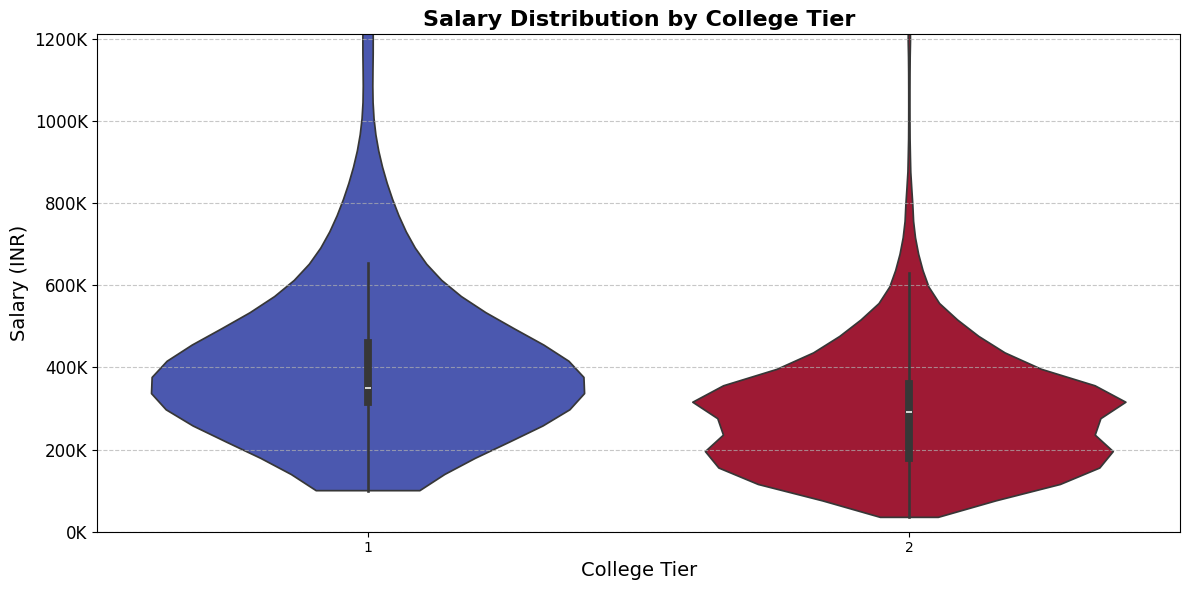

In [58]:
plt.figure(figsize=(12, 6))

# Violin plot with updated parameters for future versions
sns.violinplot(
    x='CollegeTier',
    y='Salary',
    data=copy_data,
    hue='CollegeTier',  # Define hue explicitly
    palette='coolwarm',
    density_norm='width',  # Update 'scale' to 'density_norm'
    cut=0,  # Don't display values outside the range
    legend=False  # Remove legend to prevent warnings
)

# Add title and labels
plt.title("Salary Distribution by College Tier", fontsize=16, fontweight='bold')
plt.xlabel("College Tier", fontsize=14)
plt.ylabel("Salary (INR)", fontsize=14)

# Customize Y-axis ticks for better clarity
max_salary = copy_data['Salary'].quantile(0.995)  # Exclude extreme outliers
plt.yticks(
    ticks=range(0, int(max_salary) + 200000, 200000),  # Ticks at every 200K interval
    labels=[f"{i//1000}K" for i in range(0, int(max_salary) + 200000, 200000)],
    fontsize=12
)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.ylim(0, max_salary)  # Set Y-axis limit to exclude extreme outliers
plt.show()


## Why is it Chosen as a Key Visualization?
The violin plot for Salary vs. College Tier was chosen as a key visualization because it effectively shows the distribution of salaries across different college tiers, including both the central tendency (e.g., median) and the spread of the data. The plot also highlights the density of the salary distribution, allowing us to see if there are multiple modes or skewness within each tier. This helps identify any significant differences in salary trends based on college tier, and it provides insight into the variation and outliers in the salary data, which is crucial for understanding how college tier impacts salary.

# Visualization 3: Salary vs Specialization
### Why is this Feature Significant?
Specialization is critical in determining salary as it reflects the graduate's field of expertise and the specific skills they bring to the job market. Different specializations align with distinct industries and roles, directly influencing salary potential, making it a key feature for capturing salary variability in the regression model.

represent the average salary of the top 5 and bottom 5 specializations.


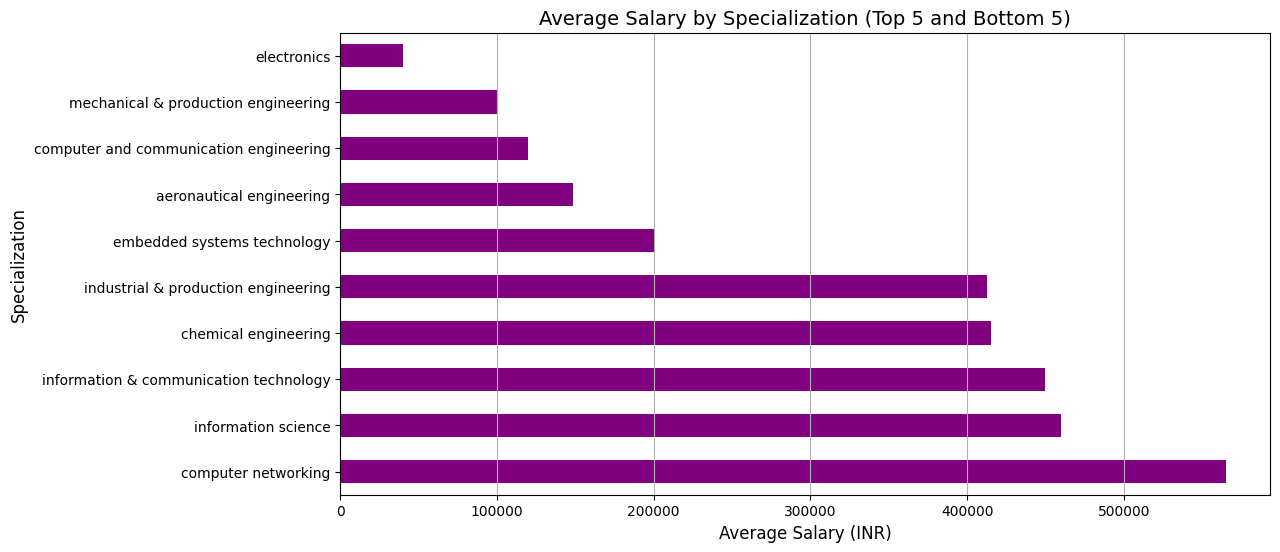

In [59]:
plt.figure(figsize=(12, 6))

# Calculate average salary by specialization and sort
avg_salary_by_spec = copy_data.groupby('Specialization')['Salary'].mean().sort_values(ascending=False)

# Select top 5 and bottom 5 specializations
top_5 = avg_salary_by_spec.head(5)
bottom_5 = avg_salary_by_spec.tail(5)

# Concatenate top 5 and bottom 5
selected_specializations = pd.concat([top_5, bottom_5])

print("represent the average salary of the top 5 and bottom 5 specializations.")

# Plot the selected specializations
selected_specializations.plot(kind='barh', color='purple')  # Change to horizontal bar plot
plt.title("Average Salary by Specialization (Top 5 and Bottom 5)", fontsize=14)
plt.xlabel("Average Salary (INR)", fontsize=12)  # Change label to match the new axis
plt.ylabel("Specialization", fontsize=12)  # Change label to match the new axis
plt.grid(axis='x')  # Change grid to match the new axis
plt.show()

## Why is it Chosen as a Key Visualization?
This visualization is chosen because it effectively showcases the average salary for each specialization clearly and intuitively, making it easy to compare the earnings across categories. The bar chart format emphasizes salary level differences, helping identify the specializations that lead to higher earnings. Additionally, this layout is particularly suited for categorical data with a large number of unique values, as it avoids the clutter that could arise with other visualizations, ensuring clarity and readability.

# Visualization 4: Salary vs Logical Score
### Why is this Feature Significant?
Logical ability is a key cognitive skill often evaluated during hiring processes. By analyzing the relationship between logical scores and salary, we can determine if higher logical reasoning skills correlate with higher salaries, providing insights into how cognitive abilities influence salary potential. 


Exclude extreme outliers for better view


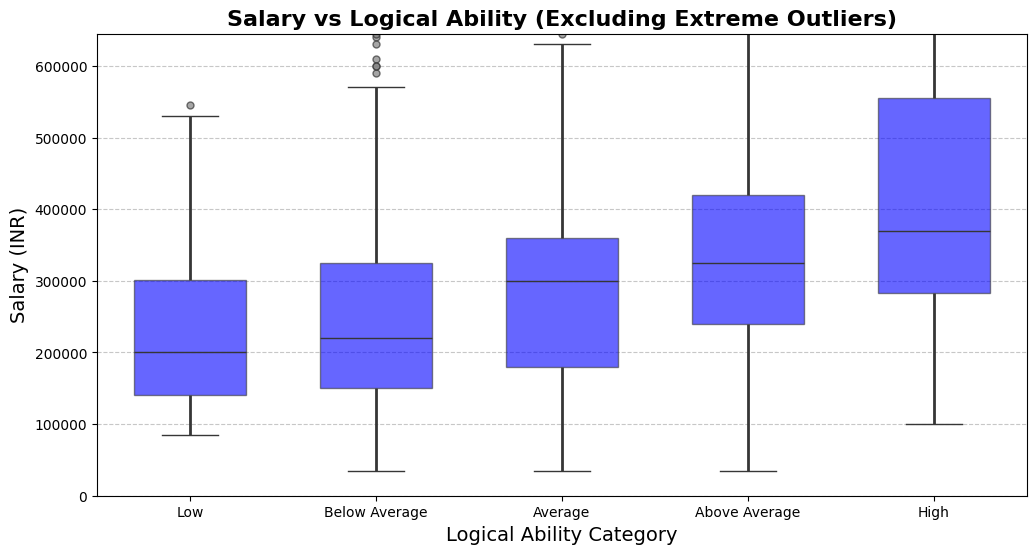

represent all data for better understanding


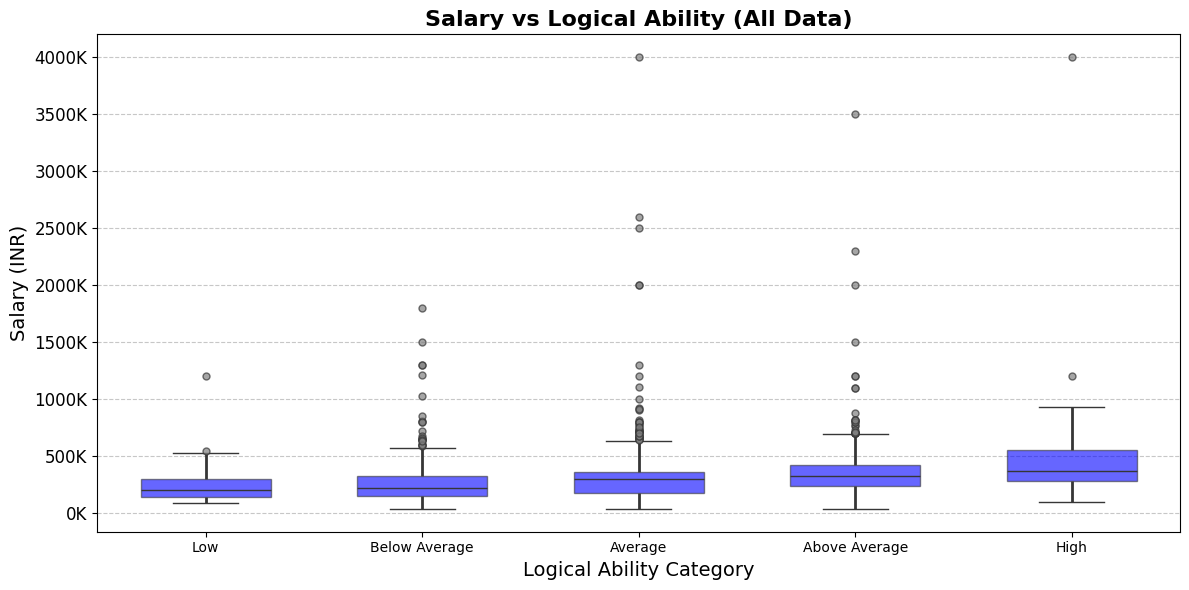

In [60]:
plt.figure(figsize=(12, 6))

# Binning logical scores for categorical analysis
copy_data['Logical_Bin'] = pd.cut(copy_data['Logical'], bins=5, labels=["Low", "Below Average", "Average", "Above Average", "High"])

# Box plot excluding extreme outliers
sns.boxplot(
    x='Logical_Bin',
    y='Salary',
    data=copy_data,
    hue='Logical_Bin',  # Explicitly assign hue to avoid future warnings
    palette='Blues',
    width=0.6,
    showcaps=True,
    boxprops={'facecolor': 'blue', 'alpha': 0.6},
    whiskerprops={'linewidth': 2},
    flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'gray', 'alpha': 0.7},
    legend=False
)

# Add title and labels
plt.title("Salary vs Logical Ability (Excluding Extreme Outliers)", fontsize=16, fontweight='bold')
plt.xlabel("Logical Ability Category", fontsize=14)
plt.ylabel("Salary (INR)", fontsize=14)

# Customize Y-axis ticks
plt.ylim(0, copy_data['Salary'].quantile(0.97))  # Exclude extreme outliers
plt.grid(axis='y', linestyle='--', alpha=0.7)

print("Exclude extreme outliers for better view")
plt.show()


plt.figure(figsize=(12, 6))

# Box plot with all data
sns.boxplot(
    x='Logical_Bin',
    y='Salary',
    data=copy_data,
    hue='Logical_Bin',  # Explicitly assign hue to avoid future warnings
    palette='Blues',
    width=0.6,
    showcaps=True,
    boxprops={'facecolor': 'blue', 'alpha': 0.6},
    whiskerprops={'linewidth': 2},
    flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'gray', 'alpha': 0.7},
    legend=False
)

# Add title and labels
plt.title("Salary vs Logical Ability (All Data)", fontsize=16, fontweight='bold')
plt.xlabel("Logical Ability Category", fontsize=14)
plt.ylabel("Salary (INR)", fontsize=14)

# Customize Y-axis ticks for better clarity
max_salary = copy_data['Salary'].max()
plt.yticks(
    ticks=range(0, int(max_salary) + 500000, 500000),  # Ticks at every 500K interval
    labels=[f"{i//1000}K" for i in range(0, int(max_salary) + 500000, 500000)],
    fontsize=12
)

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
print("represent all data for better understanding")
plt.show()

copy_data = data.copy()


## Why is it Chosen as a Key Visualization?
This visualization is chosen because it effectively demonstrates the relationship between logical ability scores and salary by categorizing scores into bins, making it easier to observe trends. The boxplot highlights the distribution, median, and variation in salaries for different logical ability levels, allowing for a clear comparison of how logical skills are potentially rewarded across categories.

# Visualization 5: Salary vs Quantitative Score
### Why is this Feature Significant?
The Quantitative Ability Score is significant because it measures an individual's proficiency in quantitative reasoning, which is a key skill in many technical and analytical roles. Higher scores in quantitative ability often correlate with better problem-solving skills, logical thinking, and the ability to handle complex tasks. These skills are highly valued by employers, particularly in high-paying positions.



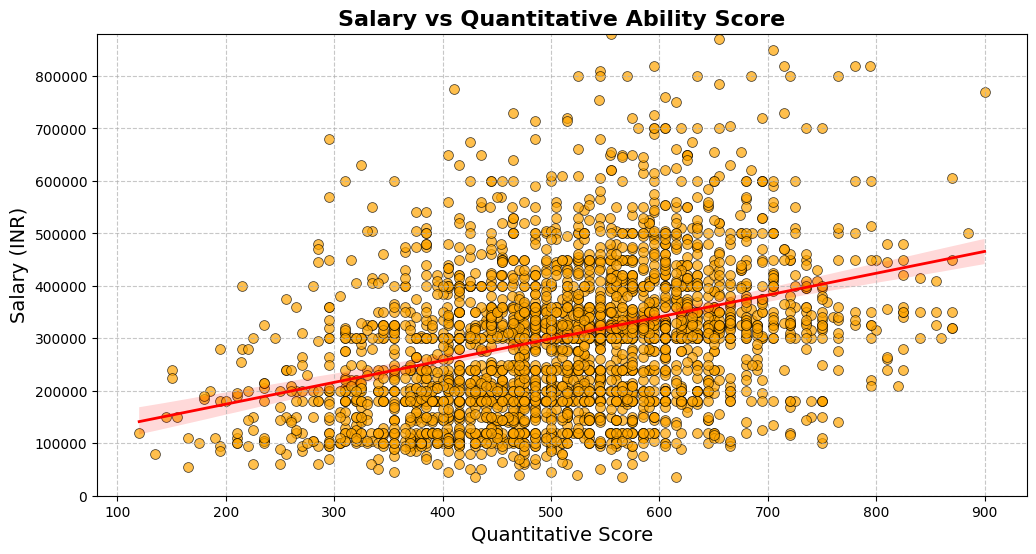

In [61]:
plt.figure(figsize=(12, 6))

# Scatter plot with regression line
sns.scatterplot(
    x='Quant',
    y='Salary',
    data=copy_data,
    color='orange',
    alpha=0.7,
    edgecolor='black',
    s=50
)
sns.regplot(
    x='Quant',
    y='Salary',
    data=copy_data,
    scatter=False,
    color='red',
    line_kws={"linewidth": 2}
)

# Add title and labels
plt.title("Salary vs Quantitative Ability Score", fontsize=16, fontweight='bold')
plt.xlabel("Quantitative Score", fontsize=14)
plt.ylabel("Salary (INR)", fontsize=14)

# Adjust Y-axis for better visualization
plt.ylim(0, copy_data['Salary'].quantile(0.99))  # Exclude extreme outliers
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Show plot
plt.show()


## Why is it Chosen as a Key Visualization?
This scatter plot with a regression line was chosen to visually represent the relationship between Quantitative Ability Scores and Salary because it allows for a clear view of both individual data points and the overall trend. By plotting this score against Salary, we can easily identify whether there is a positive correlation between higher quantitative scores and higher salaries, which would suggest that stronger quantitative skills are linked to better-paying job opportunities. The addition of the regression line helps to highlight the trend in the data, making it easier to assess the strength and direction of this relationship. This visualization effectively demonstrates how the ability to perform well in quantitative tasks may impact salary potential.

# preproccing

In [62]:
from sklearn.preprocessing import LabelEncoder
copy_data = data.copy()

# Remove the 'ID' column
copy_data = copy_data.drop(columns=['ID'])
    
# Label encode categorical variables
encoded_cols = LabelEncoder()

# Identify categorical columns
categorical_cols = data.select_dtypes(exclude=['number']).columns.tolist()

for col in categorical_cols:
    copy_data[col] = encoded_cols.fit_transform(copy_data[col])


print("Encoded columns done.")

Encoded columns done.


# Basic Model Pipeline 

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from scipy.stats import zscore

# Remove outliers in Salary
copy_data = copy_data[(np.abs(zscore(copy_data['Salary'])) < 3)]

# Feature selection and target variable
X = copy_data.drop(columns=['Salary'])
y = copy_data['Salary']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
    
# Train XGBoost model
model = xgb.XGBRegressor(random_state=42)
model.fit(X_train_scaled, y_train)
    
# Make predictions
y_pred = model.predict(X_test_scaled)

print("Model training complete.")

Model training complete.


# Results of the basic pipeline

In [64]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
    
print(f"Model Performance Metrics:")
print(f"RMSE: {rmse:.2f}k")
print(f"MAE: {mae:.2f}k")
print(f"R2 Score: {r2:.3f}")



Model Performance Metrics:
RMSE: 124578.05k
MAE: 93714.04k
R2 Score: 0.204


# Error Analysis
After running the basic model, we will analyze its errors to identify areas for improvement.


### A. Predicted vs Actual Salary
The "Predicted vs Actual Salary" plot is important for error analysis as it visually shows how closely the model’s predictions align with actual values. It helps identify systematic errors (overestimations or underestimations) and assess model accuracy by how close the points are to the red dashed line. This enables the identification of areas where the model performs poorly and highlights specific weaknesses for improvement.


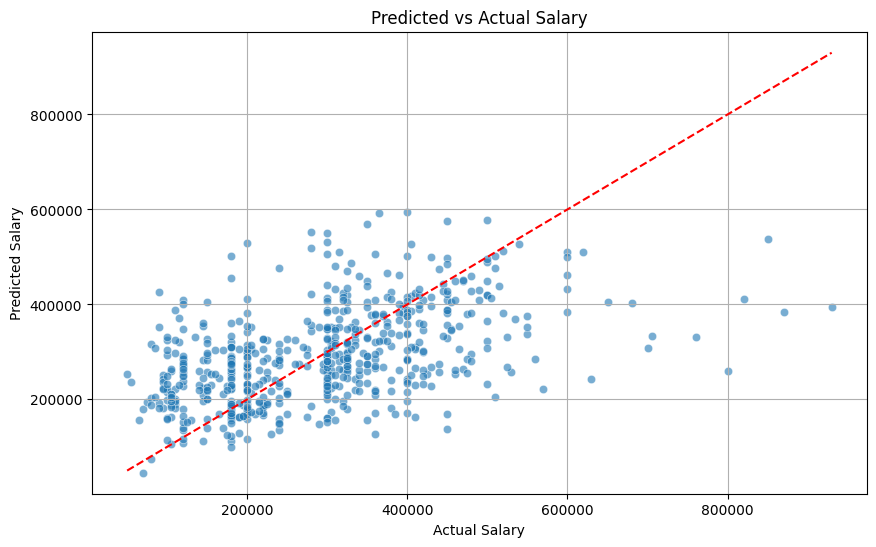

In [65]:
# Plot Predicted vs Actual
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Predicted vs Actual Salary")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.grid(True)
plt.show()

#### Insights
- **Underestimations:**
   - Points below the red line show underestimations by the model. This means the predicted salary is lower than the actual salary.
   - A significant number of points below the line at higher salary ranges indicate that the model tends to underestimate high salaries.
- **Overestimations:**
   - Points above the red line indicate overestimations, where the model predicts a salary higher than the actual value.
   - Overestimations seem to occur more frequently at lower salary ranges.
- **Error Spread:**
   - The model appears to perform better in the middle salary range (close clustering around the line) compared to very high or very low salaries, where errors are more pronounced.

- **Bias in Predictions:**
   - The model appears to struggle with predicting higher salaries accurately, often underestimating them.
   - This suggests the need to refine the model, possibly by adjusting the feature weights or incorporating more relevant features.

### B. Error Distribution
The "Error Distribution" plot is crucial in error analysis as it highlights the spread, bias, and symmetry of residuals, helping identify systematic errors (e.g., consistent over- or underestimation) and outliers, and evaluate if the residuals follow a normal distribution—essential for assessing the model's assumptions and areas needing improvement.

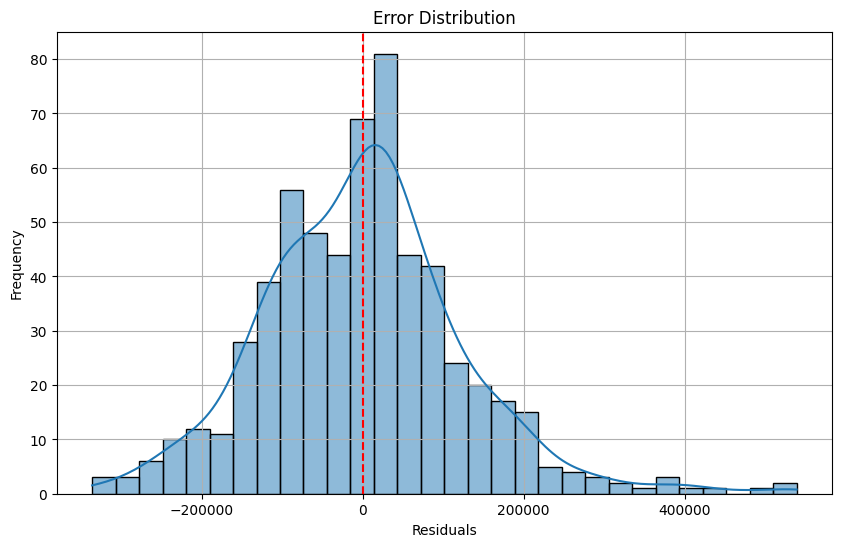

In [66]:
# Calculate residuals
residuals = y_test - y_pred


# Plot Error Distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=0, color='red', linestyle='--', label='Zero Residual (Perfect Prediction)')
plt.title("Error Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


#### Insights
- **Spread of Residuals:**
   - Most residuals fall within a range of -100,000 to 100,000. However, there are noticeable outliers beyond this range, indicating that the model struggles to predict accurately for certain cases, potentially high-salary or low-salary individuals.
- **Error Skewness:**
   - The distribution appears slightly skewed toward positive residuals. This indicates a higher frequency of underestimations (predicted salaries lower than actual) compared to overestimations.
- **Model's Performance Range:**
   - The peak of the distribution close to zero shows that the model performs well for a large proportion of predictions, but the long tails highlight areas where the model needs improvement.

### C. Top 7 and Bottom 7 Feature Importances
This plot is essential for error analysis as it identifies which features significantly impact the model's predictions. This enables targeted investigation into whether high-importance features are contributing to errors or if low-importance features are adding noise, thereby guiding improvements in feature selection and model development.

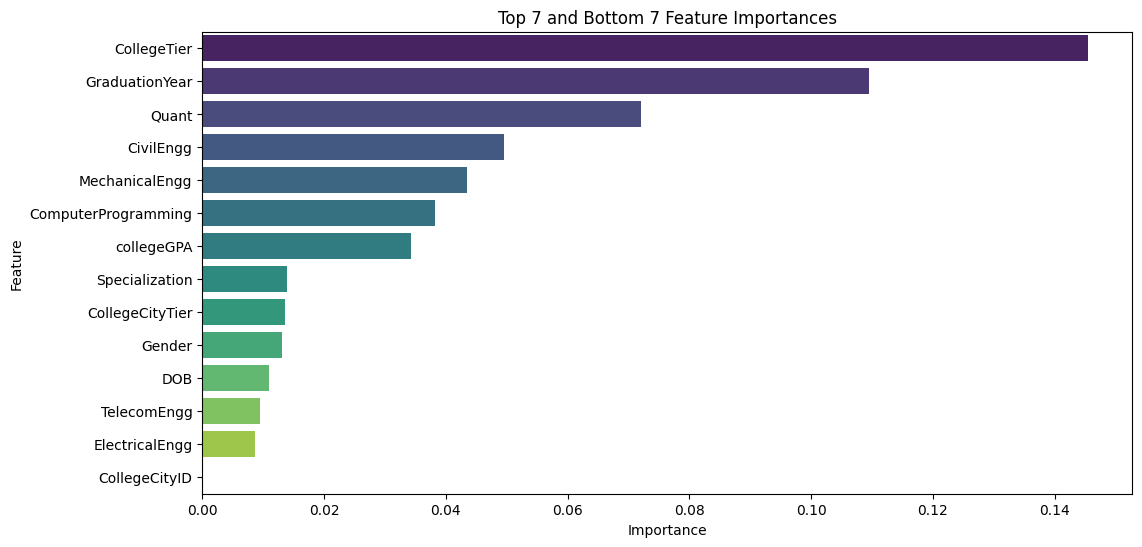

In [67]:
# Plot Feature Importance
feature_importances = model.feature_importances_
encoded_columns = X.columns.tolist()

# Create a dataframe for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': encoded_columns,
    'Importance': feature_importances
})

# Sort the dataframe by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select top 7 and bottom 7 features
top_7 = feature_importance_df.head(7)
bottom_7 = feature_importance_df.tail(7)
selected_features = pd.concat([top_7, bottom_7])

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=selected_features, palette='viridis', hue='Feature', dodge=False, legend=False)
plt.title("Top 7 and Bottom 7 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

#### Insights
- **Most Influential Features:**
   - `CollegeTier` is the most influential feature, indicating that the tier of the college plays a critical role in determining salaries.
      - Features such as `GraduationYear`, `Quant`, and `CivilEngg` follow in importance, reflecting that academic performance, graduation recency, and engineering specialization (civil engineering) are also key predictors of salary.
- **Lower-Impact Features:**
   - Features like `TelecomEngg`, `ElectricalEngg`, and `CollegeCityID` have minimal importance. This suggests that these attributes contribute little to the salary prediction and could potentially be revisited for relevance or omitted to simplify the model.
- **Model Optimization Opportunity:**
   - The clear dominance of a few features suggests a potential risk of overfitting to these attributes. It could be valuable to assess if the less important features are truly irrelevant or if they could be engineered further to add predictive value.

### D. Overestimations and Underestimations by Salary Category
This plot is important for error analysis because it categorizes errors into salary ranges, revealing whether the model consistently overestimates or underestimates within specific salary groups, enabling targeted improvements and better understanding of the model's performance across different income levels.

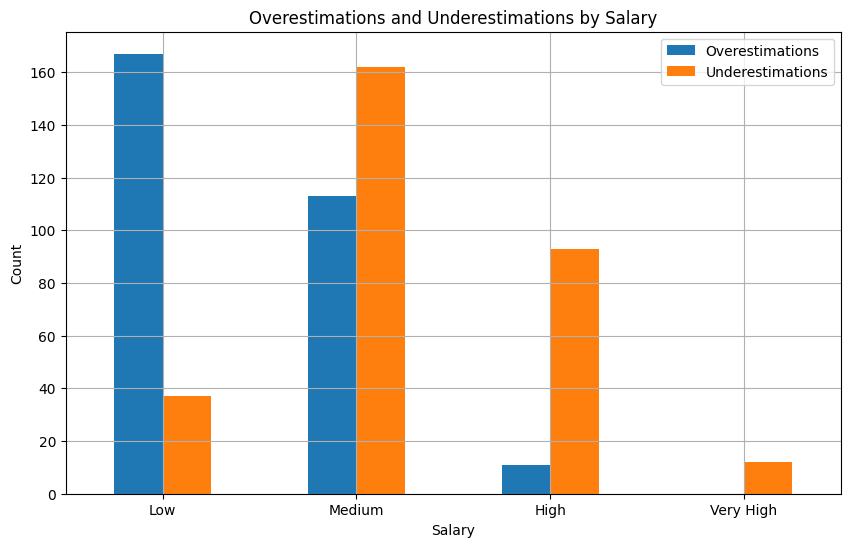

In [68]:
# Add a new column for the residuals
error_analysis_df = pd.DataFrame({
    'Actual Salary': y_test,
    'Predicted Salary': y_pred,
    'Residual': residuals
})

# Add residuals calculation
error_analysis_df['Residual'] = error_analysis_df['Actual Salary'] - error_analysis_df['Predicted Salary']

# Categorize salaries into bins (e.g., Low, Medium, High)
bins = [0, 200000, 400000, 600000, np.inf]
labels = ['Low', 'Medium', 'High', 'Very High']
error_analysis_df['Salary Category'] = pd.cut(
    error_analysis_df['Actual Salary'], bins=bins, labels=labels, include_lowest=True
)

# Initialize a DataFrame to store results
categories = ['Low', 'Medium', 'High', 'Very High']
overestimations = []
underestimations = []

# Calculate overestimations and underestimations for each category
for category in categories:
    category_data = error_analysis_df[error_analysis_df['Salary Category'] == category]
    overestimations.append((category_data['Residual'] < 0).sum())
    underestimations.append((category_data['Residual'] > 0).sum())

# Create a new DataFrame for analysis
category_analysis = pd.DataFrame({
    'Salary Category': categories,
    'Overestimations': overestimations,
    'Underestimations': underestimations
})

# Visualize the overestimations and underestimations
category_analysis.set_index('Salary Category').plot(kind='bar', figsize=(10, 6))
plt.title("Overestimations and Underestimations by Salary")
plt.xlabel("Salary")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


#### Insights
- **Low Salary Category:**
   - The model significantly **overestimates** salaries in the low salary category compared to underestimations.
   - This suggests the model might overfit certain features leading to inflated predictions for lower salary groups.
- **Medium Salary Category:**
   - Medium salaries often encompass a wide range of features and characteristics, making them harder to differentiate. This could be causing the model to overfit or underfit, leading to a higher error count in this range.
- **High Salary Category:**
   - **Underestimations dominate** in the high salary category, indicating the model fails to predict sufficiently high values for individuals with high actual salaries.
   - This could imply that features associated with high salaries are not weighted strongly enough or that the model underrepresents high-salary data in the training set.
- **Very High Salary Category:**
   - Predictions for very high salaries are predominantly **underestimated**, consistent with the trend observed for the high salary group.
   - This highlights a weakness in the model's ability to predict extreme salary values, likely due to insufficient data for this range or lack of distinguishing features for very high salaries.

## Let's examine this in a more focused way by College Tier
This plot is crucial because it is the most important feature influencing the model's predictions and has a direct correlation with salary. This analysis helps identify systematic biases, such as whether the model overestimates or underestimates specific tiers, enabling targeted improvements to refine predictions.

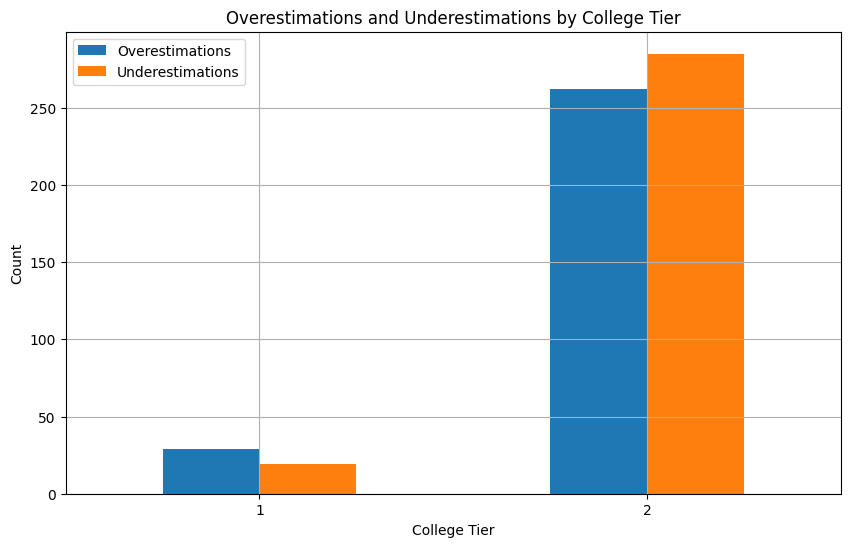

In [69]:
# Add CollegeTier to the error analysis dataframe
error_analysis_df['CollegeTier'] = X_test['CollegeTier']

# Initialize lists to store results
college_tiers = error_analysis_df['CollegeTier'].unique()
overestimations = []
underestimations = []
mean_residuals = []

# Calculate metrics for each CollegeTier
for tier in sorted(college_tiers):  # Sort for consistent output
    tier_data = error_analysis_df[error_analysis_df['CollegeTier'] == tier]
    overestimations.append((tier_data['Residual'] < 0).sum())
    underestimations.append((tier_data['Residual'] > 0).sum())
    mean_residuals.append(tier_data['Residual'].mean())

# Create a DataFrame for tier analysis
tier_analysis = pd.DataFrame({
    'CollegeTier': sorted(college_tiers),
    'Overestimations': overestimations,
    'Underestimations': underestimations,
    'Mean Residual': mean_residuals
})

# Visualize the overestimations and underestimations by College Tier
tier_analysis.set_index('CollegeTier')[['Overestimations', 'Underestimations']].plot(kind='bar', figsize=(10, 6))
plt.title("Overestimations and Underestimations by College Tier")
plt.xlabel("College Tier")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


#### Insights
- **Tier 1 (Elite Colleges):**
   - Overestimations and underestimations are significantly lower compared to Tier 2 colleges. This suggests that the model performs relatively well in predicting salaries for graduates of Tier 1 colleges, likely because their salary ranges are more consistent or easier to model based on the available features
- **Higher Error Frequency**: 
   - Most errors are concentrated in Tier 2 colleges, with underestimations slightly outnumbering overestimations. This imbalance suggests that the model has difficulty accurately predicting salaries for this group.